# Reinforcement Learning for Navigation Network Study

In [1]:
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import MultiAgentVecEnv

from mlagents_envs.exception import UnityTimeOutException, UnityWorkerInUseException
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel

import torch as th

import os, yaml
import random
import time
import datetime
import numpy as np
import torch as th
from torch import nn

from mlagents_envs.environment import UnityEnvironment
from gym_unity.envs import UnityToMultiGymWrapper 
import wandb
from rlnav.logging import WANDBMonitor, test_model
from rlnav.schedules import linear_schedule
from pathlib import Path

In [2]:
from torchsummary import summary

In [3]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\batua\anaconda3\envs\rlnav\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
device

device(type='cuda')

## The Incoming Data

![The Point the data is gathered](tmp/Observation.png "The observation")

In [5]:
observations = np.load('observation505_fixed.npy')
print("Loaded shape:", observations.shape)
observations = observations.squeeze()

vector_size    = 19 
whisker_size   = 26 + 6 # 6 represents the rotation observation which is included in depth_map component but can be ignored.
depth_size     = 55 - 6
occupancy_size = 405

vector_end    = vector_size
whisker_end   = vector_end  + whisker_size
depth_end     = whisker_end + depth_size
occupancy_end = depth_end   + occupancy_size

Loaded shape: (10000, 1, 505)


In [6]:
vec_obs       = observations[:, 0:vector_end]
whisker_obs   = observations[:, vector_end :whisker_end]
depth_obs     = observations[:, whisker_end:depth_end]
occupancy_obs = observations[:, depth_end  :occupancy_end]

assert vec_obs.shape[1]+ whisker_obs.shape[1]+ depth_obs.shape[1] + occupancy_obs.shape[1] == 505 
print(vec_obs.shape[1]+ whisker_obs.shape[1]+ depth_obs.shape[1] + occupancy_obs.shape[1])

505


## Depthmask

![The Point the data is gathered](tmp/Depthmask.png "The observation")

#### The ground is not shown. Raycasts ignore the collider if they are spawned from the inside of it.

In [7]:
depth_obs.shape

(10000, 49)

In [8]:
print(depth_obs[0])

[0.        0.        0.        0.        0.        0.9295996 0.4421997
 0.        0.        0.        0.        0.        0.9295996 0.4421997
 0.        0.        0.        0.        0.        0.9295996 0.4421997
 0.        0.        0.        0.        0.        0.9295996 0.4421997
 0.        0.        0.        0.        0.        0.9295996 0.4421997
 0.        0.        0.        0.        0.        0.9295996 0.4421997
 0.        0.        0.        0.        0.        0.9295996 0.4421997]


In [9]:
depth_obs.shape
depth_obs_2d = depth_obs.reshape(-1, 7, 7)  ### Occupancy Grid
depth_obs_2d.shape

(10000, 7, 7)

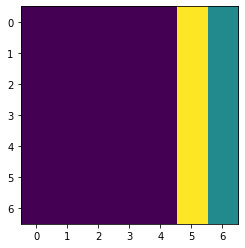

In [10]:
imshow(depth_obs_2d[100])

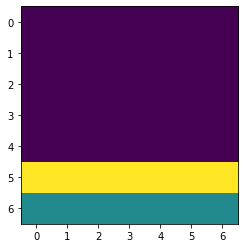

In [11]:
imshow(depth_obs_2d[100].T)

## Occupancy Grid

![The Point the data is gathered](tmp/Occupancy.png "The observation")

## (9, 5, 9) - (x,y,z) box size

In [12]:
occupancy_obs.shape
occupancy_obs_3d = occupancy_obs.reshape(-1, 9, 5, 9)
occupancy_obs_3d_plt = np.swapaxes(occupancy_obs_3d, -1, -2)

In [13]:
idx = random.randint(0,10000)
print(idx)

4072


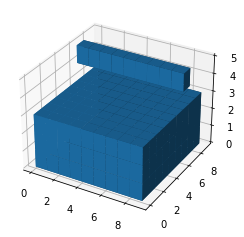

In [14]:
ax = plt.figure().add_subplot(projection='3d')
_ = ax.voxels(occupancy_obs_3d_plt[idx-1])

### Preprocessing input

In [15]:
batch_size = 512
input_tensor = th.tensor(observations[:batch_size]).cuda()
action_dim = 3

depthmap_side_size = 7
occupancy_grid_shape = (9,5,9) 

is_critic = False # When the network is the critic the actions are appended to the end of the input. policies.py 847

In [16]:
depth_obs.shape
vector_end

19

In [17]:
# This is done at every forward.
if is_critic:
    original_vector = input_tensor[:, :whisker_end]
    actions_in_critic = input_tensor[:, -action_dim:]
    vector_obs = th.cat((original_vector, actions_in_critic),dim=1)
else:
    vector_obs = input_tensor[:, :whisker_end].cuda()

depth_obs     = input_tensor[:, whisker_end: depth_end]
occupancy_obs = input_tensor[:, depth_end: occupancy_end]

depth_obs2d = depth_obs.reshape(-1, 1, depthmap_side_size, depthmap_side_size)
occupancy_obs3d = occupancy_obs.reshape(-1, 1, *occupancy_grid_shape)

In [ ]:
assert depth_obs.shape[1] == 49
assert occupancy_obs.shape[1] == 405


In [18]:
print(vector_obs.shape)
print(depth_obs2d.shape)
print(occupancy_obs3d.shape)

assert 505 == vector_obs.shape[-1] + \
              depth_obs2d.shape[-2] * depth_obs2d.shape[-1] + \
              occupancy_obs3d.shape[-3] * occupancy_obs3d.shape[-2] * occupancy_obs3d.shape[-1]

torch.Size([512, 51])
torch.Size([512, 1, 7, 7])
torch.Size([512, 1, 9, 5, 9])


### Depthmap Layers

In [19]:
depth_obs2d.shape

torch.Size([512, 1, 7, 7])

In [20]:
class MyGlobal2DMaxPoolLayer(nn.Module): #Is this the correct name?
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return th.mean(x, dim =(-2,-1))

In [21]:
def create_depthmap_layers(): 
    conv2d_size = 64
    depthmap_layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=conv2d_size, kernel_size=3, padding=2, stride=1), nn.ReLU(),
        nn.Conv2d(conv2d_size,   out_channels=conv2d_size, kernel_size=3, padding=2, stride=1), nn.ReLU(),
        MyGlobal2DMaxPoolLayer(),
    ) 
    return depthmap_layers

depthmap_layers = create_depthmap_layers()
depthmap_layers.cuda()

depthmap_layers_output_shape = depthmap_layers(depth_obs2d).shape[-1]
summary(depthmap_layers, depth_obs2d.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 9, 9]             640
              ReLU-2             [-1, 64, 9, 9]               0
            Conv2d-3           [-1, 64, 11, 11]          36,928
              ReLU-4           [-1, 64, 11, 11]               0
MyGlobal2DMaxPoolLayer-5                   [-1, 64]               0
Total params: 37,568
Trainable params: 37,568
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.20
Params size (MB): 0.14
Estimated Total Size (MB): 0.34
----------------------------------------------------------------


### Occupancy Layers

In [22]:
class MyGlobal3DMaxPoolLayer(nn.Module): #Is this the correct name?
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return th.mean(x, dim=(-3, -2,-1))

In [23]:
def create_occupancy_layers():
    conv3d_size = 32
    occupancy_layers = nn.Sequential(
        nn.Conv3d(in_channels=1, out_channels=conv3d_size, kernel_size=3, padding=2, stride=1), nn.ReLU(),
        nn.Conv3d(conv3d_size,   out_channels=conv3d_size, kernel_size=3, padding=2, stride=1), nn.ReLU(),
        MyGlobal3DMaxPoolLayer()
    )
    return occupancy_layers

occupancy_layers = create_occupancy_layers()
occupancy_layers.cuda()
occupancy_layers_output_shape = occupancy_layers(occupancy_obs3d.cuda()).shape[-1]

summary(occupancy_layers, occupancy_obs3d.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 32, 11, 7, 11]             896
              ReLU-2        [-1, 32, 11, 7, 11]               0
            Conv3d-3        [-1, 32, 13, 9, 13]          27,680
              ReLU-4        [-1, 32, 13, 9, 13]               0
MyGlobal3DMaxPoolLayer-5                   [-1, 32]               0
Total params: 28,576
Trainable params: 28,576
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.16
Params size (MB): 0.11
Estimated Total Size (MB): 1.27
----------------------------------------------------------------


### Vector Layers

In [24]:
def create_vector_layers():
    hidden_dim = 512
    vector_layers = nn.Sequential(
        nn.Linear(vector_obs.shape[-1], hidden_dim), nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim), 
    )
    return vector_layers

vector_layers = create_vector_layers()
vector_layers.cuda()

Sequential(
  (0): Linear(in_features=51, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=512, bias=True)
)

### Combine Layers

In [25]:
hidden_dim = 512
combo_model = nn.Sequential(
    nn.Linear(hidden_dim + occupancy_layers_output_shape + depthmap_layers_output_shape, hidden_dim), nn.ReLU(),
    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
)
combo_model.cuda()

Sequential(
  (0): Linear(in_features=608, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): ReLU()
)

In [26]:
depth_output     = th.squeeze(depthmap_layers(depth_obs2d.cuda()))
occupancy_output = th.squeeze(occupancy_layers(occupancy_obs3d.cuda()))
vector_output    = th.squeeze(vector_layers(vector_obs.cuda()))

# Get the combination and pass it through the last linear layers.
combined_input = th.cat((vector_output, occupancy_output, depth_output), dim=1)
output = combo_model(combined_input)

### Full Network

In [40]:
class RLCustomNetwork(nn.Module):
    def __init__(self):
        super(RLCustomNetwork, self).__init__()
        self.create_model()
    
    def create_model(self):
        conv2d_size = 32
        conv3d_size = 32
        hidden_dim = 512
        
        self.depthmap_layers = create_depthmap_layers().cuda()
        
        self.occupancy_layers= create_occupancy_layers().cuda()
        
        self.vector_layers = create_vector_layers().cuda()
        
        self.combo_model = nn.Sequential(
            nn.Linear(hidden_dim + occupancy_layers_output_shape + depthmap_layers_output_shape, hidden_dim), nn.ReLU(),
        ).cuda()
        
       
    def forward(self, input_tensor):
        if is_critic:
            original_vector = input_tensor[:, :whisker_end]
            actions_in_critic = input_tensor[:, -action_dim:]
            vector_obs = th.cat((original_vector, actions_in_critic),dim=1).cuda()
        else:
            vector_obs = input_tensor[:, :whisker_end].cuda() # Vectorend includes whiskers

        depth_obs     = input_tensor[:, whisker_end: depth_end]
        occupancy_obs = input_tensor[:, depth_end: occupancy_end]

        depth_obs2d = depth_obs.reshape(-1, 1, depthmap_side_size, depthmap_side_size) # 1 is the filter size
        occupancy_obs3d = occupancy_obs.reshape(-1, 1, *occupancy_grid_shape)
        
        depth_output     = th.squeeze(self.depthmap_layers(depth_obs.reshape(-1, 1, depthmap_side_size, depthmap_side_size)))
        occupancy_output = th.squeeze(self.occupancy_layers(occupancy_obs.reshape(-1, 1, *occupancy_grid_shape)))
        vector_output    = self.vector_layers(vector_obs)
        
        combined_input = th.cat((vector_output, occupancy_output, depth_output), dim=1)
        output = self.combo_model(combined_input)
        
        return output

In [41]:
net = RLCustomNetwork()
net(input_tensor).shape

torch.Size([512, 512])

In [42]:
summary(net, input_tensor.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 9, 9]             640
              ReLU-2             [-1, 64, 9, 9]               0
            Conv2d-3           [-1, 64, 11, 11]          36,928
              ReLU-4           [-1, 64, 11, 11]               0
MyGlobal2DMaxPoolLayer-5                   [-1, 64]               0
            Conv3d-6        [-1, 32, 11, 7, 11]             896
              ReLU-7        [-1, 32, 11, 7, 11]               0
            Conv3d-8        [-1, 32, 13, 9, 13]          27,680
              ReLU-9        [-1, 32, 13, 9, 13]               0
MyGlobal3DMaxPoolLayer-10                   [-1, 32]               0
           Linear-11                  [-1, 512]          26,624
             ReLU-12                  [-1, 512]               0
           Linear-13                  [-1, 512]         262,656
           Linear-14          

# PROFILING

In [30]:
# Default network trace profiler: https://wandb.ai/batu/Urban/artifacts/profile/trace-z1crfyl9/dea233bef8b2339f4b0e/files/trace.pt.trace.json
# Custom network: https://wandb.ai/batu/Urban/artifacts/profile/trace-1mxyn7xs/1c4f8c37348d7efb23d8/files/trace.pt.trace.json

In [31]:
import pstats
from pstats import SortKey

In [32]:
# #   net_arch: 
# #     pi: 
# #       - 512
# #       - 512
# #     qf:
# #       - 1024
# #       - 1024
# #       - 1024
# # trainable params: 11m
# # mlp_mini 

# mlp = pstats.Stats('profiling/mlp.file')
# mlp.sort_stats("tottime").print_stats(10)

In [50]:
# trainable params: 1176679
# Custom built network 

mlp = pstats.Stats('profiling/mlp.file')
mlp.sort_stats("tottime").print_stats(50)

Thu Aug 26 11:54:36 2021    profiling/mlp.file

         14161923 function calls (13514469 primitive calls) in 296.383 seconds

   Ordered by: internal time
   List reduced from 12736 to 50 due to restriction <50>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      967  205.194    0.212  205.194    0.212 {built-in method _winapi.WaitForMultipleObjects}
     9984   15.185    0.002   15.185    0.002 {method 'run_backward' of 'torch._C._EngineBase' objects}
   102249    8.329    0.000    8.329    0.000 {built-in method torch._C._nn.linear}
    56576    5.357    0.000    6.339    0.000 c:\users\batua\desktop\rlnav\rlagency\stable-baselines3\stable_baselines3\common\utils.py:365(zip_strict)
    17521    5.087    0.000    5.088    0.000 {method 'to' of 'torch._C._TensorBase' objects}
      477    3.759    0.008    3.759    0.008 {method 'acquire' of '_thread.lock' objects}
    13312    3.510    0.000    3.510    0.000 {method 'item' of 'torch._C._TensorBase' object

# MLP

In [34]:
 296.3 - 205 

91.30000000000001

In [44]:
572 - 221

351

In [36]:
25000 / 64 * 256

100000.0

In [49]:
# trainable params: 6076679
# Custom built network 

custom_default = pstats.Stats('profiling/custom_default.file')
custom_default.sort_stats("tottime").print_stats(10)

Thu Aug 26 11:48:28 2021    profiling/custom_default.file

         22640713 function calls (20719753 primitive calls) in 572.867 seconds

   Ordered by: internal time
   List reduced from 12740 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      967  221.673    0.229  221.673    0.229 {built-in method _winapi.WaitForMultipleObjects}
    17589  101.472    0.006  101.473    0.006 {method 'to' of 'torch._C._TensorBase' objects}
    13312   88.619    0.007   88.619    0.007 {method 'item' of 'torch._C._TensorBase' objects}
     9984   37.219    0.004   37.219    0.004 {method 'run_backward' of 'torch._C._EngineBase' objects}
    10803   13.235    0.001   14.405    0.001 C:\Users\batua\anaconda3\envs\rlnav\lib\site-packages\torch\distributions\distribution.py:34(__init__)
    96512    9.498    0.000   11.620    0.000 c:\users\batua\desktop\rlnav\rlagency\stable-baselines3\stable_baselines3\common\utils.py:365(zip_strict)
    54864   

# CONV2d / CONV3d

In [39]:
# trainable params: 6076679
# Custom built network with slicing done converted to and back from numpy

custom_numpyslice = pstats.Stats('profiling/custom_numpyslice.file')
custom_numpyslice.sort_stats("tottime").print_stats(10)

Thu Aug 26 12:13:01 2021    profiling/custom_numpyslice.file

         22954041 function calls (21033095 primitive calls) in 619.846 seconds

   Ordered by: internal time
   List reduced from 12753 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      967  225.374    0.233  225.374    0.233 {built-in method _winapi.WaitForMultipleObjects}
    28230  103.479    0.004  103.479    0.004 {method 'cpu' of 'torch._C._TensorBase' objects}
    17589   82.290    0.005   82.291    0.005 {method 'to' of 'torch._C._TensorBase' objects}
     9984   36.352    0.004   36.352    0.004 {method 'run_backward' of 'torch._C._EngineBase' objects}
    10803   15.429    0.001   16.821    0.002 C:\Users\batua\anaconda3\envs\rlnav\lib\site-packages\torch\distributions\distribution.py:34(__init__)
    13312   14.546    0.001   14.546    0.001 {method 'item' of 'torch._C._TensorBase' objects}
    82281   12.137    0.000   12.137    0.000 {method 'cuda' of 't

In [45]:
# trainable params: 3610087
# Custom built network  with Adam

custom_new = pstats.Stats('profiling/custom_new.file')
custom_new.sort_stats("tottime").print_stats(10)

Thu Aug 26 13:55:55 2021    profiling/custom_new.file

         23680886 function calls (21840620 primitive calls) in 1379.732 seconds

   Ordered by: internal time
   List reduced from 12757 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    13312  545.294    0.041  545.294    0.041 {method 'item' of 'torch._C._TensorBase' objects}
    17609  289.391    0.016  289.392    0.016 {method 'to' of 'torch._C._TensorBase' objects}
      967  234.159    0.242  234.159    0.242 {built-in method _winapi.WaitForMultipleObjects}
    10803  123.615    0.011  125.501    0.012 C:\Users\batua\anaconda3\envs\rlnav\lib\site-packages\torch\distributions\distribution.py:34(__init__)
     9984   46.179    0.005   46.179    0.005 {method 'run_backward' of 'torch._C._EngineBase' objects}
   109824   11.302    0.000   13.715    0.000 c:\users\batua\desktop\rlnav\rlagency\stable-baselines3\stable_baselines3\common\utils.py:365(zip_strict)
   117167   11.

In [46]:
# trainable params: 3610087
# Custom built network  with Adam

only_cpu = pstats.Stats('profiling/only_cpu.file')
only_cpu.sort_stats("tottime").print_stats(10)

22.995533333333334